In [1]:
!pip install nibabel

In [2]:
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Dataset
from ipywidgets import IntSlider, interact
from matplotlib import animation, rc
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.path import Path
from scipy import ndimage
from scipy.ndimage import zoom



In [3]:
seed = 27

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:
config = {
    'learning_rate': 1e-4,
    'lr_decay_rate': 0.96,
    'epochs': 100,
    'batch_size': 4,
    'img_size': 128,
    'depth': 64
}

In [5]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min_hu = -1000
    max_hu = 400
    volume[volume < min_hu] = min_hu
    volume[volume > max_hu] = max_hu
    volume = (volume - min_hu) / (max_hu - min_hu)
    return volume.astype('float32')

def resize_volume(img, desired_width=128, desired_height=128, desired_depth=64):
    """Resize the volume"""
    # Compute zoom factors
    width_factor = desired_width / img.shape[0]
    height_factor = desired_height / img.shape[1]
    depth_factor = desired_depth / img.shape[-1]
    # Rotate volume by 90 degrees
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize the volume using spline interpolated zoom (SIZ)
    img = zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(
        volume, config['img_size'], config['img_size'], config['depth']
    )
    return volume


In [6]:
# Create directories
output_dir = os.path.join(os.getcwd(), "MosMedData")
os.makedirs(output_dir, exist_ok=True)

normal_scan_paths = [os.path.join(output_dir, "CT-0", x) for x in os.listdir(os.path.join(output_dir, "CT-0"))]
abnormal_scan_paths = [os.path.join(output_dir, "CT-23", x) for x in os.listdir(os.path.join(output_dir, "CT-23"))]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))



CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [7]:
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
validation_split = 0.3
n_train_samples = int((1 - validation_split) * len(abnormal_scans))


x_train = np.concatenate(
    (abnormal_scans[:n_train_samples], normal_scans[:n_train_samples]), axis=0
)
y_train = np.concatenate(
    (abnormal_labels[:n_train_samples], normal_labels[:n_train_samples]), axis=0
)
x_val = np.concatenate(
    (abnormal_scans[n_train_samples:], normal_scans[n_train_samples:]), axis=0
)
y_val = np.concatenate(
    (abnormal_labels[n_train_samples:], normal_labels[n_train_samples:]), axis=0
)
print(
    'Number of samples in train and validation are %d and %d.'
    % (x_train.shape[0], x_val.shape[0])
)


Number of samples in train and validation are 140 and 60.


In [8]:
def rotate(volume):
    """Rotate the volume by a few degrees using PyTorch and SciPy"""
    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick an angle at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume
    
    # Convert the tensor to a numpy array
    volume_np = volume.numpy()
    # Apply the rotation using SciPy
    rotated_volume = scipy_rotate(volume_np)
    # Convert the numpy array back to a tensor
    return torch.tensor(rotated_volume, dtype=torch.float32)

def train_preprocessing(volume):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = volume.permute(2, 0, 1)
    # Add a channel dimension
    volume = volume.unsqueeze(0)  # Add channel dimension at axis 0
    return volume

def validation_preprocessing(volume):
    """Process validation data by only adding a channel."""
    volume = volume.permute(2, 0, 1)
    # Add a channel dimension
    volume = volume.unsqueeze(0)  # Add channel dimension at axis 0
    return volume

In [9]:
class CTScanDataset(Dataset):
    def __init__(self, scans, labels, transform=None):
        self.scans = scans
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.scans)

    def __getitem__(self, idx):
        scan = self.scans[idx]
        label = self.labels[idx]

        if self.transform:
            scan = self.transform(scan)

        return scan, label
    
    
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)
x_val_tensor = torch.tensor(x_val)
y_val_tensor = torch.tensor(y_val)

# Create datasets
train_dataset = CTScanDataset(x_train_tensor, y_train_tensor, transform=train_preprocessing)
validation_dataset = CTScanDataset(x_val_tensor, y_val_tensor, transform=validation_preprocessing)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=config['batch_size'], shuffle=False)

for inputs, labels in train_loader:
        print(inputs.shape)
        break

torch.Size([4, 1, 64, 128, 128])


<class 'torch.Tensor'>
Dimensions of the CT scan are: (1, 64, 128, 128)


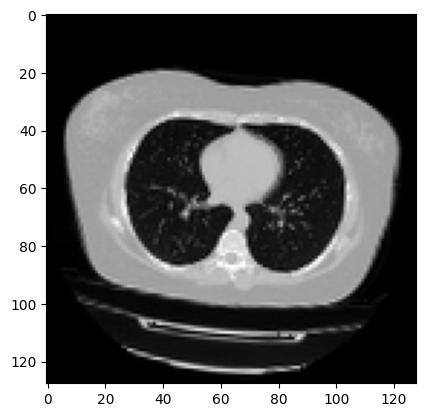

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Get a single batch from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Convert the images to numpy arrays
print(type(images))
# images = images[0]
images = images.numpy()
image = images[0]

print('Dimensions of the CT scan are:', image.shape)

# Visualize a slice from the 3D CT scan
plt.imshow(np.squeeze(image[0, 30, :, :, ]), cmap='gray')
plt.show()

(1, 64, 128, 128)


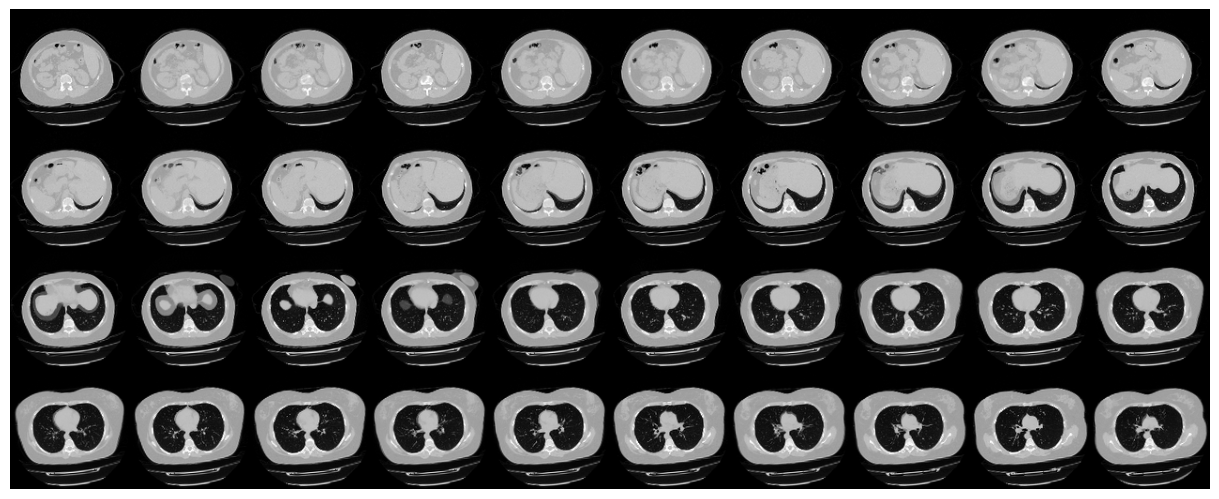

In [11]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    _, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios': heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap='gray')
            axarr[i, j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
print(image.shape)
image = image[0]
t_image = np.transpose(image, (1, 2, 0))
plot_slices(4, 10, 128, 128, t_image[:, :, :40])

In [12]:
class Conv3DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(Conv3DBlock, self).__init__()
        self.conv3d = nn.Conv3d(in_channels, out_channels, kernel_size, padding=1)
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool3d(2)
        self.batchnorm = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        x = self.conv3d(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.batchnorm(x)
        return x

class CNN3D(nn.Module):
    def __init__(self, width=128, height=128, depth=64):
        super(CNN3D, self).__init__()
        self.conv1 = Conv3DBlock(1, 64)
        self.conv2 = Conv3DBlock(64, 64)
        self.conv3 = Conv3DBlock(64, 128)
        self.conv4 = Conv3DBlock(128, 256)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Build model
model = CNN3D().to(device)
print(model)


Using device: cuda
CNN3D(
  (conv1): Conv3DBlock(
    (conv3d): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (activation): ReLU()
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Conv3DBlock(
    (conv3d): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (activation): ReLU()
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Conv3DBlock(
    (conv3d): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (activation): ReLU()
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [13]:
torch.cuda.empty_cache()

In [14]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
best_val_loss = float('inf') 
prev_val_acc = 0

history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

# Learning rate scheduler
def lr_schedule(epoch):
    return config['learning_rate'] * (config['lr_decay_rate'] ** (epoch // 100000))

# Train the model
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).squeeze(1).float()
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)
        
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_correct / total
    return train_loss, train_acc

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)
            
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.unsqueeze(1)).item() * inputs.size(0)
            
            preds = (outputs > 0.5).squeeze(1).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_acc = correct / total
    return val_loss, val_acc

# Main training loop
for epoch in range(config['epochs']):
    # Update learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_schedule(epoch)
        
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, epoch)
    val_loss, val_acc = validate(model, validation_loader, criterion)
    
    print(f'Epoch {epoch+1}/{config["epochs"]}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Save the model if validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '3d_image_classification.pth')
    
    # After training loop, append the performance metrics to history for visualization
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    # Early stopping
    if epoch > 50 and val_acc < prev_val_acc:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    prev_val_acc = val_acc


Epoch 1/100, Train Loss: 0.6568, Train Acc: 0.6429, Val Loss: 1.5506, Val Acc: 0.5000
Epoch 2/100, Train Loss: 0.6381, Train Acc: 0.6357, Val Loss: 0.7321, Val Acc: 0.5833
Epoch 3/100, Train Loss: 0.6299, Train Acc: 0.6071, Val Loss: 0.6285, Val Acc: 0.6333
Epoch 4/100, Train Loss: 0.6186, Train Acc: 0.6357, Val Loss: 0.6360, Val Acc: 0.6667
Epoch 5/100, Train Loss: 0.6445, Train Acc: 0.5714, Val Loss: 0.6189, Val Acc: 0.6833
Epoch 6/100, Train Loss: 0.6038, Train Acc: 0.6714, Val Loss: 0.6188, Val Acc: 0.6833
Epoch 7/100, Train Loss: 0.5742, Train Acc: 0.6857, Val Loss: 0.6096, Val Acc: 0.7000
Epoch 8/100, Train Loss: 0.5942, Train Acc: 0.6571, Val Loss: 0.6968, Val Acc: 0.5833
Epoch 9/100, Train Loss: 0.6198, Train Acc: 0.6714, Val Loss: 0.7717, Val Acc: 0.5833
Epoch 10/100, Train Loss: 0.6437, Train Acc: 0.6000, Val Loss: 0.6128, Val Acc: 0.6667
Epoch 11/100, Train Loss: 0.5642, Train Acc: 0.7000, Val Loss: 0.6154, Val Acc: 0.7000
Epoch 12/100, Train Loss: 0.5917, Train Acc: 0.7143,

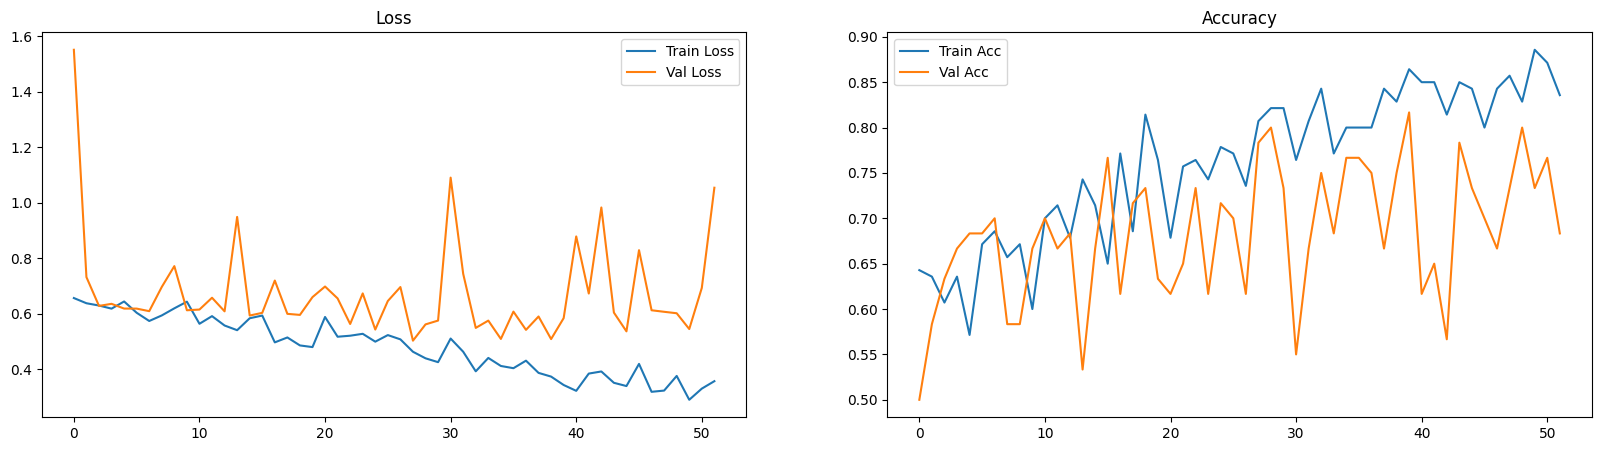

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(history['train_loss'], label='Train Loss')
ax[0].plot(history['val_loss'], label='Val Loss')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(history['train_acc'], label='Train Acc')
ax[1].plot(history['val_acc'], label='Val Acc')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [16]:
model.load_state_dict(torch.load("3d_image_classification.pth"))
model.eval()

with torch.no_grad():
    sample = torch.tensor(x_val[0]).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)
    prediction = model(sample).item()
    scores = [1 - prediction, prediction]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(f"This model is {score * 100:.2f} percent confident that CT scan is {name}")

This model is 80.12 percent confident that CT scan is normal
This model is 19.88 percent confident that CT scan is abnormal


In [17]:
import torch
import torch.nn.functional as F
import numpy as np

def make_gradcam_heatmap(img_tensor, model, last_conv_layer_name, pred_index=None):
    """Generate class activation heatmap"""
    # First, we create a hook to store the activations and gradients
    activations = {}
    gradients = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activations['conv4'] = output
        return hook
    
    def get_gradients(name):
        def hook(module, grad_in, grad_out):
            gradients['conv4'] = grad_out[0]
        return hook
    
    # Register hooks to capture activations and gradients
    last_conv_layer = dict(model.named_modules())[last_conv_layer_name]
    last_conv_layer.register_forward_hook(get_activation(last_conv_layer_name))
    last_conv_layer.register_backward_hook(get_gradients(last_conv_layer_name))
    
    # Make a forward pass to get predictions and activations
    model.eval()
    output = model(img_tensor)
    
    if pred_index is None:
        pred_index = torch.argmax(output, dim=1)
    
    class_output = output[:, pred_index].squeeze()
    
    # Backward pass to get gradients
    model.zero_grad()
    class_output.backward(retain_graph=True)
    
    # Get the captured gradients and activations
    activations = activations[last_conv_layer_name].detach().cpu().numpy()
    gradients = gradients[last_conv_layer_name].detach().cpu().numpy()
    
    # Compute the weights
    pooled_grads = np.mean(gradients, axis=(0, 2, 3))
    
    # Compute the heatmap
    for i in range(pooled_grads.shape[0]):
        activations[:, i, :, :] *= pooled_grads[i]
    
    heatmap = np.mean(activations, axis=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

# Example usage
# Assuming your model's last conv layer is named 'conv4'
last_conv_layer_name = 'conv4'

# Create a sample input tensor
sample = torch.tensor(x_val[0]).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(sample, model, last_conv_layer_name)

print("heatmap generated")

heatmap generated


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


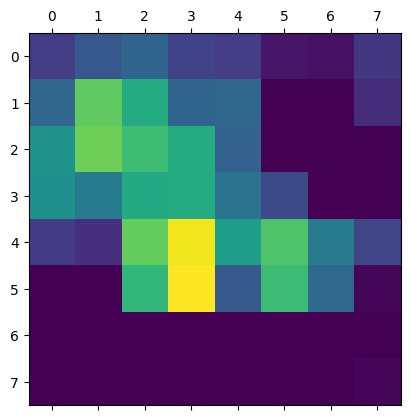

In [18]:
plt.matshow(np.squeeze(heatmap[:, :, 1]))
plt.show()

In [19]:
# Resize heatmap

def get_resized_heatmap(heatmap, shape):
    upscaled_heatmap = zoom(heatmap, (shape[0] / heatmap.shape[0], shape[1] / heatmap.shape[1], shape[2] / heatmap.shape[2]))
    upscaled_heatmap = np.uint8(255 * upscaled_heatmap)
    return upscaled_heatmap

resized_heatmap = get_resized_heatmap(heatmap, x_val[0].shape)


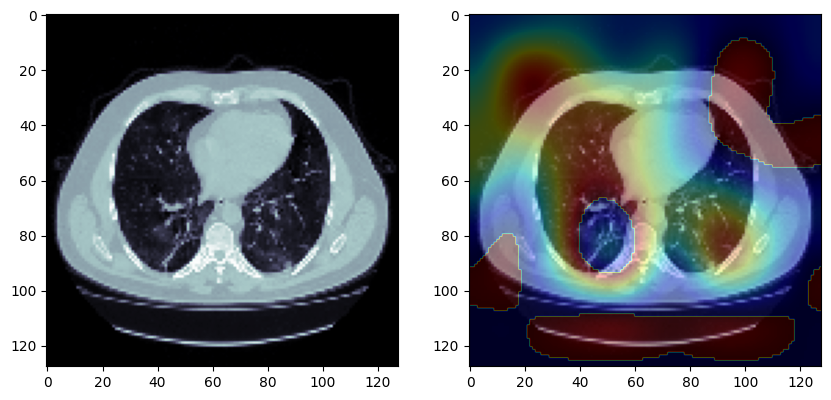

In [20]:
# Visualize heatmap
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(x_val[0][:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(x_val[0][:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]), cmap='jet', alpha=0.3, extent=img0.get_extent())

plt.show()
